In [1]:
from __future__ import print_function
import numpy as np
import numpy.linalg as LA
from scipy import optimize
from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import gen_mat as gen
import grad_log_det as log_det # this is a module with analytical calculation of gradient and objective 
%matplotlib inline
from block_rect_maxvol import test_points_gen
from autograd import grad
from numba import jit, njit, prange


In [2]:
# Workspace
"""
Here should be defined parameters of approximation:
– number of columns in model matrix (num_col)
– number of points using for approximation (num_points)
– dimension of the model (dim)
– bounds of domain (l_bound, u_bound)
– function to be approximated (def rhs(points))
"""
num_col = 50
num_points = 54

num_col = 36
num_points = 154

dim = 2

log_det.num_col = num_col # this is a global variable in module log_det
log_det.dim = dim         # this is a global variable in module log_det

assert num_col <= num_points, '! num_points < num_col !'

l_bound = -3.
u_bound = 3.

x_0 = l_bound + (u_bound - l_bound)*np.random.rand(num_points*dim) # starting point of GD
bnds = ((l_bound, u_bound),)* (dim*num_points)

def rhs(points):
    return 2*np.exp(-((points[:,0]**2)/2. + (points[:,1]**2)/2.))# + (points[:,2]**2)/2.)) # Gaussian
    #return (1 - points[:,0])**2 + 100*(points[:,1] - points[:,0]**2)**2 # Rosenbrock
    #return (np.sin((points[:,0]**2)/2. - (points[:,1]**2)/4. + 3) * np.cos(2*points[:,0] + 1 - np.exp(points[:,1]))) # Trigonometric 

print('Max degree of expansion term = ', np.max(gen.indeces_K_cut(dim, num_col)))

Max degree of expansion term =  7


In [3]:
# optimization part (BFGS)
loss_f = lambda x: log_det.loss_func(x, ToGenDiff=True)
# %time res = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = log_det.grad, factr = 10.0, bounds = bnds)
%time  res = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = grad(loss_f), factr = 10.0, bounds = bnds)

CPU times: user 47 s, sys: 1.12 s, total: 48.1 s
Wall time: 55.7 s


In [8]:
# check of the correctness of analytical gradient calculation
def cg():
    print(optimize.check_grad(log_det.loss_func, log_det.grad, x_0, epsilon=epsilon))
    
epsilon = 1e-5
# print(optimize.check_grad(log_det.loss_func, grad(log_det.loss_func), x_0, epsilon=epsilon))
%time cg()

0.0004001827352730492
CPU times: user 1.45 s, sys: 10.1 ms, total: 1.46 s
Wall time: 1.5 s


In [5]:
pnts = res[0].reshape(res[0].size//dim, dim, order="F")

In [5]:
# approximation error (infinity norm) and comparison with MaxVol
M_gd = gen.GenMat(num_col, pnts, poly = gen.cheb, ToGenDiff=False) 
c_gd = LA.solve(np.dot(M_gd.T, M_gd), np.dot(M_gd.T, rhs(pnts)))
_="""
np.random.seed(100500)
test = l_bound + (u_bound - l_bound)*np.random.rand(int(1e5), dim)

M = gen.GenMat(num_col, test, poly = gen.cheb, ToGenDiff=False) 

print("GD error = ", LA.norm(rhs(test) - np.dot(M, c_gd), np.inf) / LA.norm(rhs(test), np.inf), "\n")
# print ("rank =,", np.linalg.matrix_rank(M),", shape =", M.shape)
row_indx,_ = rect_maxvol(M, tol = 1.01, minK = num_points, maxK = num_points)

print ("MaxVol passed")

c_maxvol = LA.solve(np.dot(M[row_indx].T, M[row_indx]), np.dot(M[row_indx].T, rhs(test[row_indx])))

print("MaxVol error = ", LA.norm(rhs(test) - np.dot(M, c_maxvol), np.inf) / LA.norm(rhs(test), np.inf), "\n")


from sobol_lib import *
def GenSobol( N = 200, dim = 2, seed = 0, rng=(-1.0, 1.0) ):
    res = np.zeros((N, dim), dtype=float)
    rng_d = rng[1] - rng[0]
    for i in xrange(N):
        res[i, :], seed = i4_sobol ( dim, seed )
        res[i, :] = res[i, :]*rng_d + rng[0]

    return res

smp_sbl = GenSobol(num_points, dim, rng=(l_bound, u_bound))
M_sbl = gen.GenMat(num_col, smp_sbl, poly = gen.cheb, ToGenDiff=False)
c_sbl = LA.solve(np.dot(M_sbl.T, M_sbl), np.dot(M_sbl.T, rhs(M_sbl)))

print("Sobol error = ", LA.norm(rhs(test) - np.dot(M, c_sbl), np.inf) / LA.norm(rhs(test), np.inf), "\n")


# smp = l_bound + (u_bound - l_bound)*lhs(dim, num_points, criterion='m', iterations=100)
smp = l_bound + (u_bound - l_bound)*test_points_gen(num_points, dim, 'LHS')
M_lhs = gen.GenMat(num_col, smp, poly = gen.cheb, ToGenDiff=False)
c_lhs = LA.solve(np.dot(M_lhs.T, M_lhs), np.dot(M_lhs.T, rhs(smp)))

print("LHS error = ", LA.norm(rhs(test) - np.dot(M, c_lhs), np.inf) / LA.norm(rhs(test), np.inf), "\n")


smp_rndm = l_bound + (u_bound - l_bound)*np.random.rand(num_points, dim)
M_rndm = gen.GenMat(num_col, smp_rndm, poly = gen.cheb, ToGenDiff=False)
c_rndm = LA.solve(np.dot(M_rndm.T, M_rndm), np.dot(M_rndm.T, rhs(smp_rndm)))

print("Rand error = ", LA.norm(rhs(test) - np.dot(M, c_rndm), np.inf) / LA.norm(rhs(test), np.inf), "\n")
"""

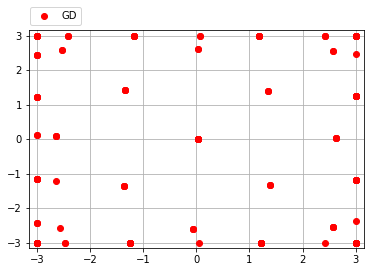

In [6]:
# visualization part
# position of the chosen points by MaxVol and GD in 2-D case
plt.xlim(l_bound-0.15, u_bound+0.15)
plt.ylim(l_bound-0.15, u_bound+0.15)
#plt.plot(M[row_indx,1], M[row_indx,2], 'ro', label = "MV")
plt.plot(pnts[:,0], pnts[:,1], 'ro', label = "GD")
#plt.plot(smp_sbl[:,0],smp_sbl[:,1], 'm*', label = "Sobol")
#plt.plot(smp[:,0],smp[:,1], 'go', label = "LHS")
#plt.plot(smp_rndm[:,0],smp_rndm[:,1], 'bx', label = "Random")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=4, borderaxespad=0.1)
plt.grid(True)
plt.show()

In [8]:
log_det.NumOfClusters(pnts)

[{0, 5, 14, 15, 39, 44, 89, 111, 123, 142},
 {1, 60},
 {2, 7, 23, 34, 73, 93, 148, 150},
 {3, 36, 45, 59, 67, 102},
 {4, 8, 32, 55, 66, 135, 140},
 {6, 51, 68, 72, 76, 95, 136, 137},
 {9, 108},
 {10, 88},
 {11, 30, 53, 64, 78, 90, 117, 126},
 {12, 26, 107},
 {13, 43, 129},
 {16, 98, 104},
 {17, 112, 113},
 {18, 37, 41, 94},
 {19, 22, 62, 63, 103, 105, 109, 128},
 {20, 35, 83, 84, 99},
 {21, 124},
 {24, 54, 65, 74, 122, 139},
 {25, 28, 29, 42, 71, 81, 86, 97},
 {27, 58, 77, 138},
 {31, 48, 61, 75, 92, 100, 115},
 {33, 49, 149},
 {38, 50, 79, 87, 91, 106, 133, 144},
 {52, 82, 127, 134},
 {56, 70},
 {57, 101, 121, 130, 143, 147},
 {69, 141, 146},
 {80, 119, 125, 151},
 {96, 114, 132},
 {110, 116, 118, 152},
 {120, 153},
 {40},
 {46},
 {47},
 {85},
 {131},
 {145}]

In [ ]:
# visualization of approximated function 
fig = plt.figure()
ax = fig.gca(projection='3d')

# make data
X = np.arange(l_bound, u_bound, 0.08)
Y = np.arange(l_bound, u_bound, 0.08)
X, Y = np.meshgrid(X, Y)

Z = 2*np.exp(-((X**2)/2. + (Y**2)/2.)) 
#Z = np.sin((X**2)/2. - (Y**2)/4. + 3) * np.cos(2*X + 1 - np.exp(Y))

# plot the surface
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.03, antialiased=False)

# customize the z axis
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Speed of d/dx

In [5]:
num = 1000
xx = l_bound + (u_bound - l_bound)*np.random.rand(num, num_points*dim)
# g = grad(log_det.loss_func)
grad_f = grad(log_det.loss_func)
# grad_f = jit(g)

In [10]:
%%time
for e in xx:
    grad_f(e)

CPU times: user 1min 4s, sys: 354 ms, total: 1min 4s
Wall time: 1min 5s


In [8]:
%%time
for e in xx:
    log_det.grad(e, False)

CPU times: user 6.9 s, sys: 92.6 ms, total: 6.99 s
Wall time: 6.98 s
